In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''

import tensorflow as tf
import numpy as np
import numpy.random as rng
from data_loader.data_generator import MNISTDataGenerator, LinearDataGenerator
from models.npmodels import NPModel4,DirectNPModel4,AENPModel,AEDFANPModel
from trainers.sf_trainer import SFTrainer, AESFTrainer
from utils.config import process_config
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals


In [3]:
np.random.randint(0,2,size=[2])

array([0, 0])

In [4]:
# inshape=30
# hidden=20
# outshape=10
# batch_size=50
# T = rng.randn(outshape, inshape)
def traindata(batch_size):
    train_x=np.zeros((batch_size,2))
    train_y=np.zeros((batch_size))
    for i in range(batch_size):
        inp=np.random.randint(0,2,size=[1,2])
        output=operator.xor(inp[0,0],inp[0,1])
        train_x[i,:]=inp
        train_y[i]=output
    return (train_x, train_y)

In [5]:
batch_size=50

x,y=traindata(10)
x



array([[1., 1.],
       [0., 0.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 0.]])

In [6]:
y

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

In [7]:
#p = self.config.state_size[0]
p=2# inshape 
m =10# hiddenshap
j = 1#outshpae
#n = 10
var_xi = 0.1
learning_rate=0
lmda_learning_rate=1e-4
#lmda_learning_rate=0

#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha2, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
e0 = tf.ones([batch_size, 1], tf.float32)
e1 = tf.ones([batch_size, 1], tf.float32)
# e0 = tf.ones([1,batch_size], tf.float32)
# e1 = tf.ones([1,batch_size], tf.float32)

x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [8]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)

h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate
                 *grad_B)            
train_step = [new_W, new_A, new_B]
correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Also need to add eigenvector stuff
training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [9]:
init = tf.global_variables_initializer()

store_al=[]
store_df=[]
store_err=[]
with tf.Session() as sess:

    sess.run(init)
    for idx in range(5000):
        (train_x, train_y) = traindata(batch_size)
        train_x=np.float32(train_x)
        train_y=(np.float32(train_y))
        train_y=train_y.reshape((batch_size,1))#to make it [50,1] instead of [50,]
#         print(sess.run([train_step],feed_dict={x: train_x, y: train_y}))
        _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y})
        
        store_err.append(err)
        store_al.append(align)
        store_df.append(diff)
        #print(align)

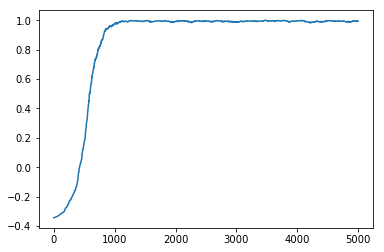

In [10]:
plt.plot(store_al)
plt.show()

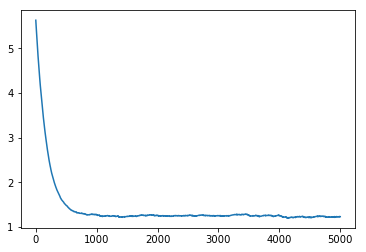

In [11]:
plt.plot(store_df)
plt.show()

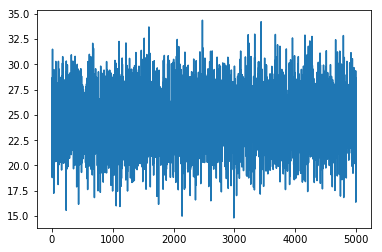

In [12]:
plt.plot(store_err)
plt.show()